In [1]:
import numpy
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import interp2d
import matplotlib.gridspec as gridspec


In [2]:
#Finds distance of a point from another point (cen)
def dist_pt_cent(pt,cen):
    #just check if the two inputs have the same dimension
    if(len(pt)!=len(cen)):
        raise Exception('pt and cen lengths do not match. The length of pt was: {}'.format(len(pt)))
    dist_vec = list(map(lambda x,y: x-y, pt,cen))
    dist_vec = list(map(lambda x: x*x ,dist_vec))
    #print(dist_vec)    
    dist = math.sqrt(sum(dist_vec))
    return dist


#Input distance of point from two centers d1 and d2
#      distance between the two centers r12
#      radii of the two atomic grids
#      becke switching function order (usually 3)
def find_becke_fac(d1,d2,r12,radii,order):
    diff=(d1-d2)/r12
    #print('diff:',diff,'r12:',r12)
    a12 = radii[0]/radii[1]
    a12 =1.0/a12 - a12
    a12 = 0.25 * a12
    if (abs(a12)>0.5):
        a12 = 0.5 * np.sign(a12)
    #print('a12:',a12)    
    fac = diff + a12*(1-diff*diff)
    for i in range(order):
        s=(1.5-0.5*fac*fac)*fac
        fac = s
        #print(i,'fac:',fac)
    return fac

#On input: 
#pt: set of points in 2d
#cen: 2d center of atoms list
#radii: radaii of at atomic grids
#order: order of becke switching (usually 3)
# output is a one dimensional array of size pt
# containing weights
def form_becke_weights(pt,cen,radii,order):
    dist_mat=numpy.zeros((len(pt),len(cen)))
    becke_weights = numpy.zeros((len(pt),len(cen)))
    p = numpy.zeros(len(cen))
    
    
    for i in range(len(pt)):
        for j in range(len(cen)):
            #print(i,j)
            #print(pt[i])
            #print(cen[j])
            dist_mat[i,j] = dist_pt_cent(pt[i],cen[j])
            #print(dist_mat)
        p=numpy.empty(len(cen)); p.fill(1.0)    
        for j in range(len(cen)):
            for k in range(len(cen)):
                if(k!=j):
                    r_jk = dist_pt_cent(cen[j],cen[k])
                    #print(j,k,'rjk:',r_jk)
                    fac = find_becke_fac(dist_mat[i,j],dist_mat[i,k],r_jk,radii,order)
                    #print('fac:',fac)
                    p[j]=p[j]*0.5*(1.0-fac)
                    p[k]=p[k]*0.5*(1.0+fac)
        norm = 0.0            
        for icen in range(len(cen)):
            #print('p:','icen:',icen,p[icen])
            norm = norm + p[icen]
            
        pb = list(map(lambda x:x/norm , p))
        
        #add Luca reweighting
        #for icen in range(len(cen)):
        #    if(dist_mat[i,icen]!=0.0):
        #        pb[icen]=pb[icen]*numpy.exp(1.e-40*(radii[icen]/dist_mat[i,icen])**10)

        
        
        for icen in range(len(cen)):
            becke_weights[i,icen] = pb[icen]
            
        #print("norm:",norm)
        
    return becke_weights


#dot product of two vectors
def dot(K, L):
    if len(K) != len(L):
        return 0

    return sum(i[0] * i[1] for i in zip(K, L))

###Test of a_ij and Bragg_Slater radii
def get_scale_factor(radii):
    cen_num = len(radii) 
    #a = numpy.zeros(shape=(cen_num,cen_num))
    ans = numpy.zeros(shape=(cen_num,cen_num))
    for i in range(len(radii)):
        for j in range(len(radii)):
            ratio = radii[i]/ radii[j]
            u = (ratio - 1)/(ratio + 1)
            a = u / (u * u - 1 )
            if(i!=j):
                ans[i][j] = -0.5*(-1 + numpy.sqrt(1+4*a*a)) / a
                if(ans[i][j]<0):
                    ans[i][j]=1+ans[i][j]
            else:
                ans[i][j] = 0.5
                

    return ans

def modify_becke(pt,bw,cen,radii):
    print(bw.shape)
    n = 5
    dist_mat=numpy.zeros((len(pt),len(cen)))
    x = numpy.zeros((len(pt),len(cen)))
    for i in range(len(pt)):
        for j in range(len(cen)):

            dist_mat[i,j] = dist_pt_cent(pt[i],cen[j])    
        
    dim1=bw.shape[0]
    dim2=bw.shape[1]
    wc = numpy.zeros((dim1))
    epsilon = numpy.log(1.e-20)
    
    
    
    for i in range(dim1):
        for icen in range(dim2):
            x[i,icen] = dist_mat[i,icen]/radii[icen]
            x[i,icen] = x[i,icen] ** (2. * n)
            bw[i,icen] = bw[i,icen]*numpy.exp( epsilon * x[i,icen])
            wc[i] = wc[i] + bw[i,icen]
        wc[i] = 1. - wc[i]
        
    return wc, bw

def modify_becke2(pt,bw,cen,radii):
    print(bw.shape)
    n = 5
    dist_mat=numpy.zeros((len(pt),len(cen)))
    x = numpy.zeros((len(pt)))
    dim1=bw.shape[0]
    dim2=bw.shape[1]
    wc = numpy.zeros((dim1))

    for i in range(len(pt)):
        for j in range(len(cen)):

            dist_mat[i,j] = dist_pt_cent(pt[i],cen[j])                     
    
    for i in range(dim1):
        for icen in range(dim2):
            x[i] = x[i] + 1./dist_mat[i,icen]
        x[i] = x[i] ** (2. * n)
                    
    for i in range(dim1):
        for icen in range(dim2):                    
            bw[i,icen] = bw[i,icen]*numpy.exp( - (1./x[i]))
            wc[i] = wc[i] + bw[i,icen]
        wc[i] = 1. - wc[i]
        
    return wc, bw

In [3]:
width = 10
height = 10
grid_z, grid_y = numpy.mgrid[-width:width:500j, -height:height:500j]
print(len(grid_z)); print(len(grid_y))
print(range(len(grid_z)))
#print(grid_z[0,149],grid_y[0,1])
# for i in zip(grid_z,grid_y):
#     for j in zip(i[0],i[1]):
#         print(j[0],j[1])


500
500
range(0, 500)


In [4]:
def make_2d_pts(x,y):
    pt=[]
    for i in zip(x,y):
        for j in zip(i[0],i[1]):
            pt.append([j[0],j[1]])
    return pt        
                       

In [5]:
pt=make_2d_pts(grid_z, grid_y)
cen = [[1.,0],[-1,0]]
radii = [10., 10.]
order = 3
w = form_becke_weights(pt,cen,radii,order)

In [6]:
print(w[1])
w1 = [item[0] for item in w ]
w2 = [item[1] for item in w ]
print(w1[1], w2[1])
print(len(w1))

[7.72648766e-08 9.99999923e-01]
7.726487658264426e-08 0.9999999227351234
250000


In [7]:
wb1=numpy.reshape(w1, (len(grid_z[0]), len(grid_z))).T
wb2 = numpy.reshape(w2, (len(grid_z[0]), len(grid_z))).T

In [8]:
250*150

37500

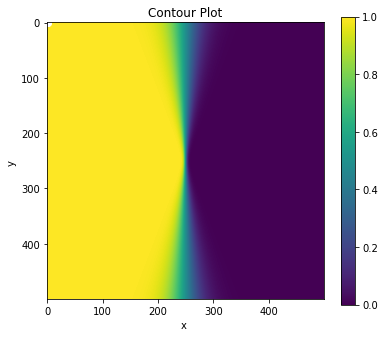

In [9]:
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])
ax.scatter(1.,0.,c='w')
cp = plt.imshow( wb2)#,origin='lower',vmin=0,vmax=max(w2))
plt.colorbar(cp)

ax.set_title('Contour Plot')
ax.set_xlabel('x ')
ax.set_ylabel('y ')
plt.show()

In [10]:
width = 10
height = 10
grid_z, grid_y = numpy.mgrid[-width:width:500j, -height:height:500j]
cen = [[0.,.6909],[2.1403, -0.3022],[-2.1403, -0.3022]]

radii = [10., 10., 10.]
order = 3
pt=make_2d_pts(grid_z, grid_y)
order = 3
w = form_becke_weights(pt,cen,radii,order)

In [11]:
w1 = [item[0] for item in w ]
w2 = [item[1] for item in w ]
w3 = [item[2] for item in w ]
wb11=numpy.reshape(w1, (len(grid_z[0]), len(grid_z)))
wb12 = numpy.reshape(w2, (len(grid_z[0]), len(grid_z)))
wb13 = numpy.reshape(w3, (len(grid_z[0]), len(grid_z)))

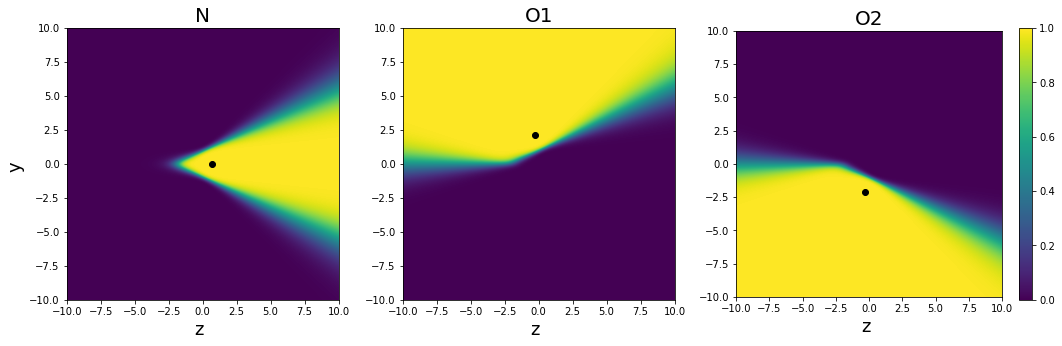

In [13]:
fig = plt.figure(figsize=(18,5))
gs = gridspec.GridSpec(1, 3,
                       width_ratios=[1,1,1.2],hspace=0.5
                       )
#left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
#ax1 = fig.add_axes([left, bottom, width, height])
width = 10
height = 10
ax1 = plt.subplot(gs[0])
ax1.scatter(.6909,0.,c='k')
ax1.imshow(wb11,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
ax2 = plt.subplot(gs[1])
ax2.scatter(-0.3022,2.1403,c='k')
ax2.imshow(wb12,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
ax3 = plt.subplot(gs[2])
ax3.scatter(-0.3022,-2.1403,c='k')
cp=ax3.imshow(wb13,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
plt.colorbar(cp)

ax1.set_title('N', Fontsize=20)
ax1.set_xlabel('z ', Fontsize=18)
ax1.set_ylabel('y ',Fontsize=18)
ax2.set_title('O1', Fontsize=20)
ax2.set_xlabel('z ', Fontsize=18)
ax3.set_title('O2', Fontsize=20)
ax3.set_xlabel('z ', Fontsize=18)
plt.savefig('Fig-BeckeTriatomicNO2.pdf', bbox_inches='tight')

In [14]:
width = 10
height = 10
grid_z, grid_y = numpy.mgrid[-width:width:500j, -height:height:500j]
print(len(grid_z)); print(len(grid_y))
print(range(len(grid_z)))
cen = [[0.,.6909],[2.1403, -0.3022],[-2.1403, -0.3022]]
radii = [10., 10., 10.]
order = 3
pt=make_2d_pts(grid_z, grid_y)
rad = 10.
radii = [rad, rad, rad]
w = form_becke_weights(pt,cen,radii,order)
wc, bw = modify_becke(pt,w,cen,radii)

500
500
range(0, 500)
(250000, 3)


In [15]:
w1 = [item[0] for item in bw ]
w2 = [item[1] for item in bw ]
w3 = [item[2] for item in bw ]

wb21 =  numpy.reshape(w1, (len(grid_z[0]), len(grid_z)))
wb22 = numpy.reshape(w2, (len(grid_z[0]), len(grid_z)))
wb23 = numpy.reshape(w3, (len(grid_z[0]), len(grid_z)))
w20  = numpy.reshape(wc, (len(grid_z[0]), len(grid_z)))

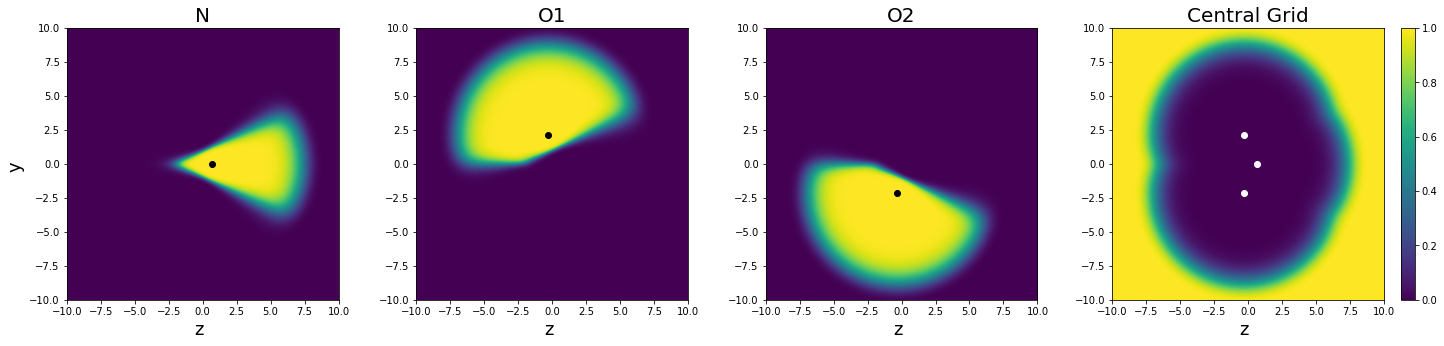

In [17]:
fig = plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1, 4,
                       width_ratios=[1,1,1,1.2],hspace=0.5
                       )
zcen =[.6909,-0.3022,-0.3022]
ycen =[0.,2.1403,-2.1403]
#left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
#ax1 = fig.add_axes([left, bottom, width, height])

ax1 = plt.subplot(gs[0])
ax1.scatter(.6909,0.,c='k')
ax1.imshow(wb21,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
ax2 = plt.subplot(gs[1])
ax2.scatter(-0.3022,2.1403,c='k')
ax2.imshow(wb22,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
ax3 = plt.subplot(gs[2])
ax3.scatter(-0.3022,-2.1403,c='k')
ax3.imshow(wb23,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)
ax4 = plt.subplot(gs[3])
ax4.scatter(zcen,ycen,c='w')
cp=ax4.imshow(w20,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
plt.colorbar(cp)

ax1.set_title('N', Fontsize=20)
ax1.set_xlabel('z ', Fontsize=18)
ax1.set_ylabel('y ',Fontsize=18)
ax2.set_title('O1', Fontsize=20)
ax2.set_xlabel('z ', Fontsize=18)
ax3.set_title('O2', Fontsize=20)
ax3.set_xlabel('z ', Fontsize=18)
ax4.set_title('Central Grid', Fontsize=20)
ax4.set_xlabel('z ', Fontsize=18)

plt.savefig('Fig-BeckeTriatomicNO2_scheme1.pdf', bbox_inches='tight')

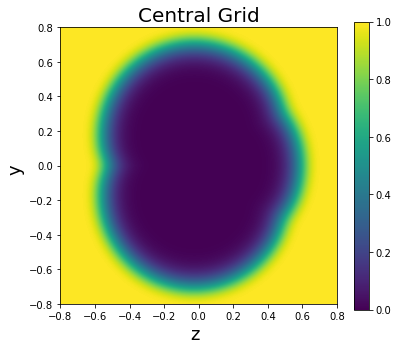

In [66]:
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])
cp = plt.imshow( w20,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
plt.colorbar(cp)

ax.set_title('Central Grid', Fontsize=20)
ax.set_xlabel('z ', Fontsize=18)
ax.set_ylabel('y ',Fontsize=18)
plt.show()

In [18]:
width = 10
height = 10
grid_z, grid_y = numpy.mgrid[-width:width:500j, -height:height:500j]
print(len(grid_z)); print(len(grid_y))
print(range(len(grid_z)))
cen = [[0.,.6909],[2.1403, -0.3022],[-2.1403, -0.3022]]
radii = [10., 10., 10.]
order = 3
pt=make_2d_pts(grid_z, grid_y)
rad = 10.
radii = [rad, rad, rad]
w = form_becke_weights(pt,cen,radii,order)

wc, bw = modify_becke2(pt,w,cen,radii)
w1 = [item[0] for item in bw ]
w2 = [item[1] for item in bw ]
w3 = [item[2] for item in bw ]

wb31=numpy.reshape(w1, (len(grid_z[0]), len(grid_z)))
wb32 = numpy.reshape(w2, (len(grid_z[0]), len(grid_z)))
wb33 = numpy.reshape(w3, (len(grid_z[0]), len(grid_z)))
w30  = numpy.reshape(wc, (len(grid_z[0]), len(grid_z)))

500
500
range(0, 500)
(250000, 3)


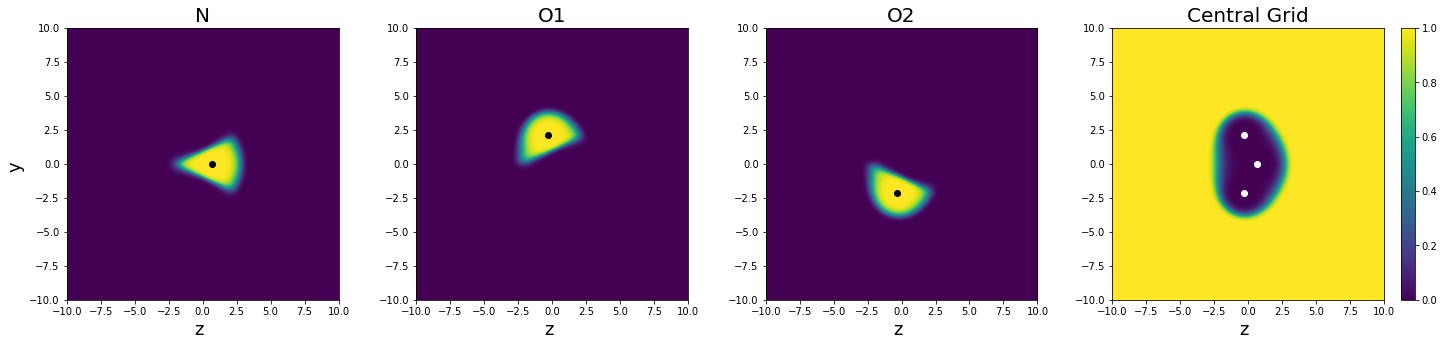

In [19]:
fig = plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1, 4,
                       width_ratios=[1,1,1,1.2],hspace=0.5
                       )
#left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
#ax1 = fig.add_axes([left, bottom, width, height])
ax1 = plt.subplot(gs[0])
ax1.scatter(.6909,0.,c='k')
ax1.imshow(wb31,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
ax2 = plt.subplot(gs[1])
ax2.scatter(-0.3022,2.1403,c='k')
ax2.imshow(wb32,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
ax3 = plt.subplot(gs[2])
ax3.scatter(-0.3022,-2.1403,c='k')
ax3.imshow(wb33,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)
ax4 = plt.subplot(gs[3])
ax4.scatter(zcen,ycen,c='w')
cp=ax4.imshow(w30,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
plt.colorbar(cp)

ax1.set_title('N', Fontsize=20)
ax1.set_xlabel('z ', Fontsize=18)
ax1.set_ylabel('y ',Fontsize=18)
ax2.set_title('O1', Fontsize=20)
ax2.set_xlabel('z ', Fontsize=18)
ax3.set_title('O2', Fontsize=20)
ax3.set_xlabel('z ', Fontsize=18)
ax4.set_title('Central Grid', Fontsize=20)
ax4.set_xlabel('z ', Fontsize=18)

plt.savefig('Fig-BeckeTriatomicNO2_scheme2.pdf', bbox_inches='tight')

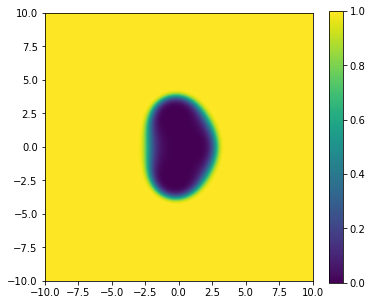

In [69]:
width = 10
height = 10
fig = plt.figure(figsize=(6,5))
#left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
#ax = fig.add_axes([width, height, width, height])
cp = plt.imshow( w30,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))
plt.colorbar(cp)

ax.set_title('Central Grid', Fontsize=20)
ax.set_xlabel('z ', Fontsize=18)
ax.set_ylabel('y ',Fontsize=18)
plt.show()

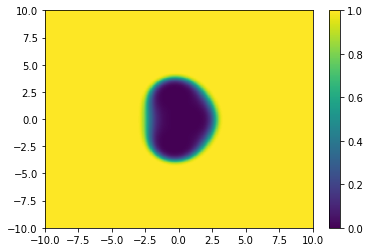

In [71]:
f, ax = plt.subplots()

im=ax.pcolormesh(grid_y, grid_z, w30)
f.colorbar(im, shrink=1)

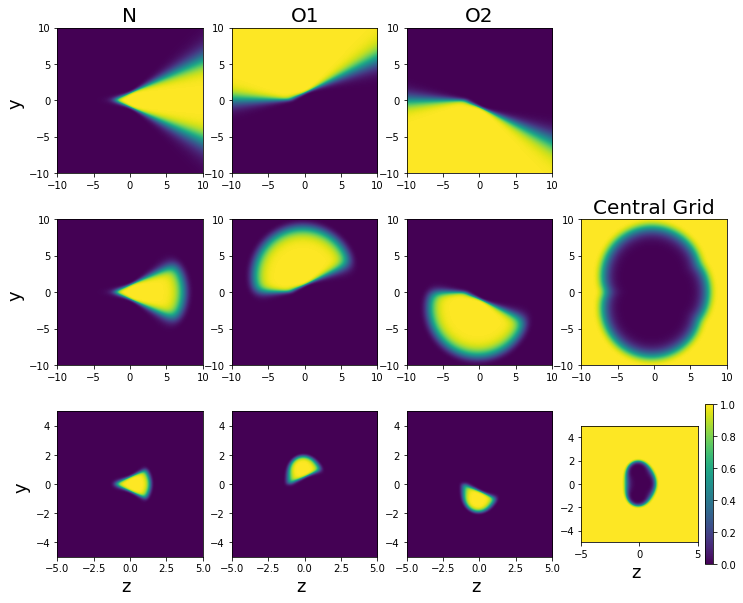

In [42]:
# gridspec inside gridspec
f = plt.figure(figsize=(12, 10))

gs0 = gridspec.GridSpec(1, 1, figure=f)

gs00 = gridspec.GridSpecFromSubplotSpec(3, 4, subplot_spec=gs0[0])
gs0.update(wspace=0.025, hspace=0.05)
ax1 = f.add_subplot(gs00[0, :1])
ax2 = f.add_subplot(gs00[0, 1:2])
ax3 = f.add_subplot(gs00[0, 2:3])
ax4 = f.add_subplot(gs00[1, :1])
ax5 = f.add_subplot(gs00[1, 1:2])
ax6 = f.add_subplot(gs00[1, 2:3])
ax7 = f.add_subplot(gs00[1, 3:4])
ax8 = f.add_subplot(gs00[2, :1])
ax9 = f.add_subplot(gs00[2, 1:2])
ax10 = f.add_subplot(gs00[2, 2:3])
ax11 = f.add_subplot(gs00[2, 3:4])

width = 10
height = 10

ax1.imshow(wb11,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)
ax2.imshow(wb12,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)
cp=ax3.imshow(wb13,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)
plt.colorbar(cp)

ax1.set_title('N', Fontsize=20)
ax8.set_xlabel('z ', Fontsize=18)
ax1.set_ylabel('y ',Fontsize=18)
ax4.set_ylabel('y ',Fontsize=18)
ax8.set_ylabel('y ',Fontsize=18)
ax2.set_title('O1', Fontsize=20)
ax9.set_xlabel('z ', Fontsize=18)
ax3.set_title('O2', Fontsize=20)
ax10.set_xlabel('z ', Fontsize=18)
ax11.set_xlabel('z ', Fontsize=18)
ax7.set_title('Central Grid', Fontsize=20)

ax4.imshow(wb21,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))

ax5.imshow(wb22,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))

ax6.imshow(wb23,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)

ax7.imshow(w20,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))


width = 5
height = 5
ax8.imshow(wb31,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))

ax9.imshow(wb32,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))

ax10.imshow(wb33,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)

ax11.imshow(w30,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)#,origin='lower',vmin=0,vmax=max(w2))




In [72]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def get_axis_limits(ax, scale=.75):
    return ax.get_xlim()[0]*scale, ax.get_ylim()[1]*scale

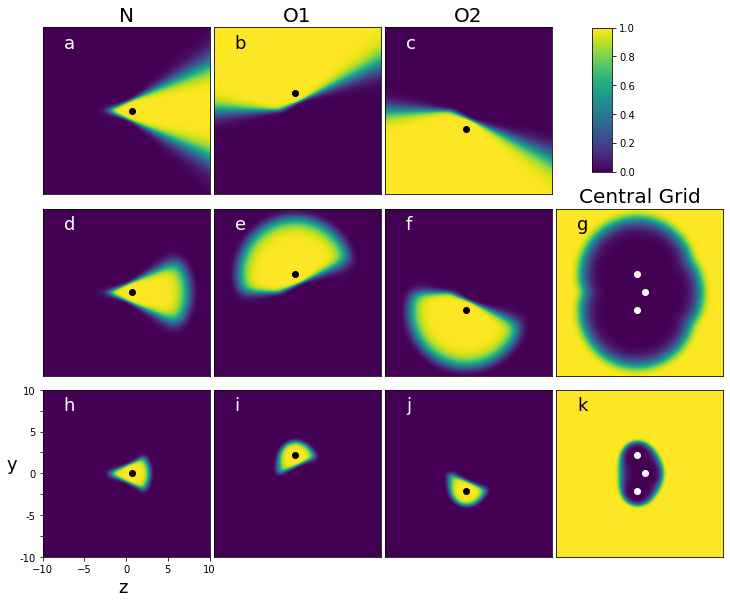

In [73]:
zcen =[.6909,-0.3022,-0.3022]
ycen =[0.,2.1403,-2.1403]

fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(nrows=3, ncols=4, height_ratios=[1, 1, 1], wspace=0.025, hspace=0)
width = 10
height = 10
#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
ax0.scatter(.6909,0.,c='k')
ax0.imshow(wb11,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)
ax0.set_title('N', Fontsize=20)
#ax0.set_ylabel('y ',Fontsize=18)
ax0.set_yticklabels([])
ax0.set_xticklabels([])
ax0.get_xaxis().set_ticks([])
ax0.get_yaxis().set_ticks([])
ax0.annotate('a', xy=get_axis_limits(ax0),color='w', fontsize=18)


ax1 = fig.add_subplot(gs[0, 1])
ax1.scatter(-0.3022,2.1403,c='k')
ax1.imshow(wb12,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)
ax1.set_title('O1', Fontsize=20)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax1.annotate('b', xy=get_axis_limits(ax1),color='k', fontsize=18)

ax2 = fig.add_subplot(gs[0, 2])
ax2.scatter(-0.3022,-2.1403,c='k')
im=ax2.imshow(wb13,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)
ax2.set_title('O2', Fontsize=20)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax2.annotate('c', xy=get_axis_limits(ax2),color='w', fontsize=18)

#fig.add_subplot(gs[0,3],)
#fig.colorbar(im, cax=fig.add_subplot(gs[0,3]),ax=ax2,shrink=0.5)

ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(.6909,0.,c='k')
ax3.imshow(wb21,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)
#ax3.set_title('N', Fontsize=20)
#ax3.set_ylabel('y ',Fontsize=18)
ax3.set_yticklabels([])
ax3.set_xticklabels([])
ax3.get_xaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])
ax3.annotate('d', xy=get_axis_limits(ax3),color='w', fontsize=18)

ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(-0.3022,2.1403,c='k')
ax4.imshow(wb22,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)
#ax4.set_title('O1', Fontsize=20)
ax4.set_yticklabels([])
ax4.set_xticklabels([])
ax4.get_xaxis().set_ticks([])
ax4.get_yaxis().set_ticks([])
ax4.annotate('e', xy=get_axis_limits(ax4),color='w', fontsize=18)

ax5 = fig.add_subplot(gs[1, 2])
ax5.scatter(-0.3022,-2.1403,c='k')
ax5.imshow(wb23,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)
ax5.set_yticklabels([])
ax5.set_xticklabels([])
#ax5.set_title('O2', Fontsize=20)
ax5.set_yticklabels([])
ax5.get_xaxis().set_ticks([])
ax5.get_yaxis().set_ticks([])
ax5.annotate('f', xy=get_axis_limits(ax5),color='w', fontsize=18)


ax6 = fig.add_subplot(gs[1, 3])
ax6.scatter(zcen,ycen,c='w')
ax6.imshow(w20,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)
ax6.set_title('Central Grid', Fontsize=20)
ax6.get_xaxis().set_ticks([])
ax6.get_yaxis().set_ticks([])
ax6.set_yticklabels([])
ax6.set_xticklabels([])
ax6.annotate('g', xy=get_axis_limits(ax6),color='k', fontsize=18)

ax7 = fig.add_subplot(gs[2, 0])
ax7.scatter(.6909,0.,c='k')
ax7.imshow(wb31,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)
#ax3.set_title('N', Fontsize=20)
ax7.set_ylabel('y ',Fontsize=18,rotation=0)
ax7.set_xlabel('z ', Fontsize=18)
ax7.set_yticklabels([-10,'',-5,'',0,'',5,'',10])
ax7.annotate('h', xy=get_axis_limits(ax7),color='w', fontsize=18)

ax8 = fig.add_subplot(gs[2, 1])
ax8.scatter(-0.3022,2.1403,c='k')
ax8.imshow(wb32,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)
#ax4.set_title('O1', Fontsize=20)
#ax8.set_xlabel('z ', Fontsize=18)
ax8.set_yticklabels([])
ax8.set_xticklabels([])
ax8.get_xaxis().set_ticks([])
ax8.get_yaxis().set_ticks([])
ax8.annotate('i', xy=get_axis_limits(ax8),color='w', fontsize=18)

#ax9.set_yticklabels([])
ax9 = fig.add_subplot(gs[2, 2])
ax9.scatter(-0.3022,-2.1403,c='k')
ax9.imshow(wb33,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)
#ax5.set_title('O2', Fontsize=20)
ax9.set_yticklabels([])
ax9.set_xticklabels([])
ax9.get_xaxis().set_ticks([])
ax9.get_yaxis().set_ticks([])
ax9.annotate('j', xy=get_axis_limits(ax9),color='w', fontsize=18)


#ax9.set_xlabel('z ', Fontsize=18)
ax10 = fig.add_subplot(gs[2, 3])
ax10.scatter(zcen,ycen,c='w')
ax10.imshow(w30,aspect='equal',extent=[-width,width,-height,height],origin=[0,0], vmin=0., vmax=1.0)
ax10.set_yticklabels([])
ax10.set_xticklabels([])
ax10.get_xaxis().set_ticks([])
ax10.get_yaxis().set_ticks([])
ax10.annotate('k', xy=get_axis_limits(ax10),color='k', fontsize=18)
#ax10.set_xlabel('z ', Fontsize=18)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.67, 0.67, 0.02, 0.20])
fig.colorbar(im, cax=cbar_ax)

plt.savefig('Fig-BeckeTriatomicNO2_Allschemes.pdf', bbox_inches='tight')